In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
from core.quantum_error_correction_code import SurfaceCode, QEC
from core.neural_network import CNNDual, load_params
from core.evaluate_decoder import evaluate_mcnn_decoder, evaluate_pml_decoder

from jax import random
import jax.numpy as jnp

key = random.key(42)

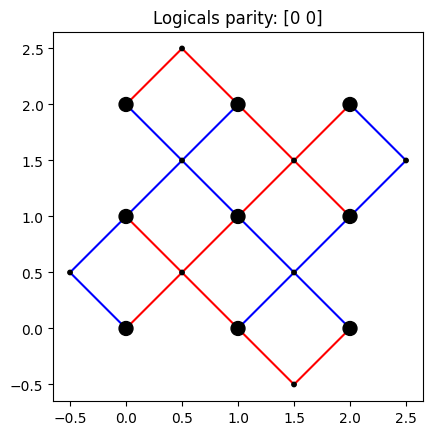

In [3]:
code = SurfaceCode(3)

deformation, key = code.random_deformation(key, jnp.zeros(code.num_data_qubits, dtype=jnp.int32))

parity_info = code.deformation_parity_info(deformation)

code.show(parity_info)

In [4]:
settings, model_params = load_params("data/CNN-G-3.json")
L = settings["CODE_DISTANCE"]
error_probs = settings["ERROR_PROBS"]

decoder_model = CNNDual(
    input_shape_1=(1, L+1, L+1),
    input_shape_2=(1, L, L),
    conv_layers_input_1=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_1"]],
    conv_layers_input_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_INPUT_2"]],
    conv_layers_stage_2=[tuple(int(v) for v in vals) for vals in settings["CONV_LAYERS_STAGE_2"]],
    fc_layers=[int(v) for v in settings["FC_LAYERS"]],
)
decoder_model.layer_sizes

{'CNN_input_1': [(1, 4, 4), (8, 3, 3)],
 'CNN_input_2': [(1, 3, 3), (8, 3, 3)],
 'CNN_stage_2': [(8, 3, 3), (8, 2, 2)],
 'MLP_stage_3': [32, 50, 2]}

# CNN-G decoder

## Random search

In [ ]:
def random_search_cnng(
    key,
    code: QEC,
    N=1000,
):
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count=1,
            batch_size=100_000,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
    return best_deformation, best_error_rate

In [ ]:
best_deformation, best_error_rate = random_search_cnng(
    random.key(42),
    code,
    N=100,
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [2 4 2 1 4 1 0 3 0] 	 Error Rate: 3.80E-04
Iteration 3/100 	 Deformation: [4 3 3 5 2 4 4 5 5] 	 Error Rate: 1.80E-04
Iteration 5/100 	 Deformation: [4 5 5 2 5 0 1 4 5] 	 Error Rate: 1.70E-04
Iteration 39/100 	 Deformation: [0 3 0 5 1 5 4 5 3] 	 Error Rate: 1.60E-04
Iteration 60/100 	 Deformation: [4 5 4 3 4 4 2 1 1] 	 Error Rate: 7.00E-05
Solution 		 Deformation: [4 5 4 3 4 4 2 1 1] 	 Error Rate: 7.00E-052.90E-04


Best error rate: 7.00E-05


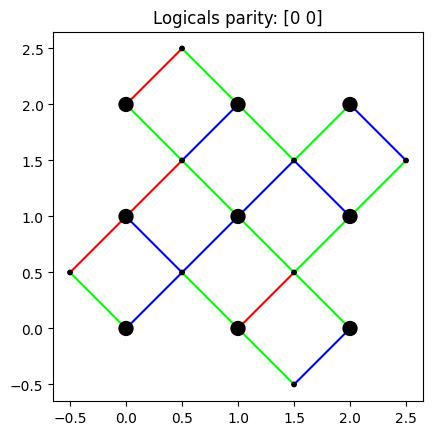

In [16]:
parity_info = code.deformation_parity_info(best_deformation)

print(f"Best error rate: {best_error_rate:.2E}")
code.show(parity_info)

## Hill climb search

In [ ]:
def hill_climb_search_cnng(
    key,
    code: QEC,
    N=1000,
):
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_mcnn_decoder(
        key,
        decoder_model,
        model_params,
        code,
        best_deformation,
        batch_count=1,
        batch_size=1_000_000,
        error_probs=error_probs,
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_mcnn_decoder(
            key,
            decoder_model,
            model_params,
            code,
            deformation,
            batch_count=1,
            batch_size=100_000,
            error_probs=error_probs,
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                break
    return best_deformation, best_error_rate

In [ ]:
best_deformation, best_error_rate = hill_climb_search_cnng(
    random.key(42),
    code,
    N=100,
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [0 0 0 0 0 0 0 4 0] 	 Error Rate: 1.40E-03		
Iteration 2/100 	 Deformation: [0 0 0 0 0 0 0 5 0] 	 Error Rate: 1.28E-03		
Iteration 3/100 	 Deformation: [0 0 0 0 2 0 0 5 0] 	 Error Rate: 6.90E-04		
Iteration 4/100 	 Deformation: [0 0 0 0 2 0 0 3 0] 	 Error Rate: 5.90E-04		
Iteration 9/100 	 Deformation: [0 0 0 4 2 0 0 3 0] 	 Error Rate: 2.70E-04		
Iteration 11/100 	 Deformation: [0 3 0 4 2 0 0 3 0] 	 Error Rate: 2.00E-04		
Iteration 12/100 	 Deformation: [0 3 0 4 2 0 5 3 0] 	 Error Rate: 1.10E-04		
Iteration 25/100 	 Deformation: [0 3 0 0 2 0 5 3 0] 	 Error Rate: 5.00E-05		
No more candidates, stopping search. 0 0 2 0 0 3 0] 	 Error Rate: 9.00E-05		
Solution 		 Deformation: [0 3 0 0 2 0 5 3 0] 	 Error Rate: 5.00E-05		


Best error rate: 5.00E-05


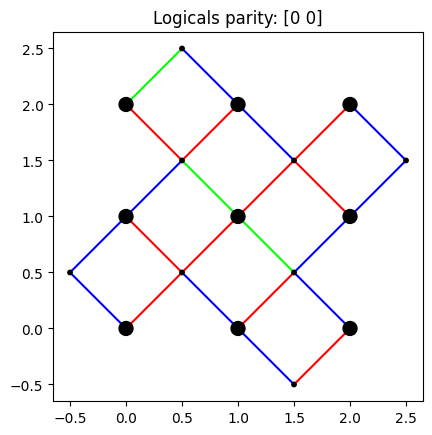

In [21]:
parity_info = code.deformation_parity_info(best_deformation)

print(f"Best error rate: {best_error_rate:.2E}")
code.show(parity_info)

# PML decoder

## Random search

In [5]:
def random_search_pml(
    key,
    code: QEC,
    N=1000,
    exact=False,
):
    best_deformation = jnp.empty(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate = jnp.inf
    for i in range(N):
        deformation, key = code.random_deformation(key, allowed_deformations=jnp.arange(6))
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count=1,
            batch_size=100_000,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
    return best_deformation, best_error_rate

In [6]:
best_deformation, best_error_rate = random_search_pml(
    random.key(42),
    code,
    N=100,
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [2 4 2 1 4 1 0 3 0] 	 Error Rate: 3.30E-04		
Iteration 3/100 	 Deformation: [4 3 3 5 2 4 4 5 5] 	 Error Rate: 7.00E-05		
Iteration 5/100 	 Deformation: [4 5 5 2 5 0 1 4 5] 	 Error Rate: 6.00E-05		
Iteration 8/100 	 Deformation: [4 2 1 0 3 3 5 1 4] 	 Error Rate: 3.00E-05		
Iteration 73/100 	 Deformation: [4 1 5 4 1 4 2 2 2] 	 Error Rate: 2.00E-05		
Solution 		 Deformation: [4 1 5 4 1 4 2 2 2] 	 Error Rate: 2.00E-05		00E-05		


In [7]:
best_deformation, best_error_rate = random_search_pml(
    random.key(42),
    code,
    N=100,
    exact=True
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [2 4 2 1 4 1 0 3 0] 	 Error Rate: 3.45E-04		
Iteration 3/100 	 Deformation: [4 3 3 5 2 4 4 5 5] 	 Error Rate: 6.76E-05		
Iteration 5/100 	 Deformation: [4 5 5 2 5 0 1 4 5] 	 Error Rate: 6.39E-05		
Iteration 8/100 	 Deformation: [4 2 1 0 3 3 5 1 4] 	 Error Rate: 5.37E-05		
Iteration 14/100 	 Deformation: [5 4 2 2 0 5 2 1 3] 	 Error Rate: 4.83E-05		
Iteration 17/100 	 Deformation: [3 0 2 2 3 2 1 2 5] 	 Error Rate: 3.71E-05		
Iteration 19/100 	 Deformation: [5 5 0 2 4 2 1 2 4] 	 Error Rate: 3.71E-05		
Iteration 29/100 	 Deformation: [2 2 1 3 1 5 3 0 4] 	 Error Rate: 3.65E-05		
Solution 		 Deformation: [2 2 1 3 1 5 3 0 4] 	 Error Rate: 3.65E-05		59E-05		


Best error rate: 3.65E-05


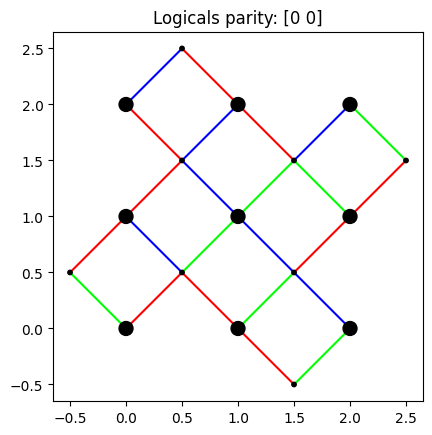

In [8]:
parity_info = code.deformation_parity_info(best_deformation)

print(f"Best error rate: {best_error_rate:.2E}")
code.show(parity_info)

## Hill climb search

In [9]:
def hill_climb_search_pml(
    key,
    code: QEC,
    N=1000,
    exact=False
):
    local_changes = lambda deformation: [
        deformation.at[n].set(d) 
        for n in range(code.num_data_qubits) 
        for d in range(6) 
        if deformation[n] != d
    ]

    best_deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    best_error_rate, _ = evaluate_pml_decoder(
        key,
        code,
        best_deformation,
        batch_count=1,
        batch_size=100_000,
        error_probs=error_probs,
        exact=exact
    )
    deformation_candidates = local_changes(best_deformation)
    for i in range(N):
        print(f"Iteration {i+1}/{N}     ", end="\r")
        subkey, key = random.split(key)
        idx = random.randint(subkey, 1, minval=0, maxval=len(deformation_candidates))[0]
        deformation = deformation_candidates[idx]
        error_rate, _ = evaluate_pml_decoder(
            key,
            code,
            deformation,
            batch_count=1,
            batch_size=100_000,
            error_probs=error_probs,
            exact=exact
        )
        print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\r")
        if error_rate < best_error_rate:
            print(f"Iteration {i+1}/{N} \t Deformation: {deformation} \t Error Rate: {error_rate:.2E}\t\t", end="\n")
            best_error_rate = error_rate
            best_deformation = deformation
            deformation_candidates = local_changes(best_deformation)
        else:
            deformation_candidates.pop(idx)
            if len(deformation_candidates) == 0:
                print("No more candidates, stopping search.\t\t\t\t\t")
                break
    return best_deformation, best_error_rate

In [10]:
best_deformation, best_error_rate = hill_climb_search_pml(
    random.key(42),
    code,
    N=100,
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [0 0 0 0 0 0 0 4 0] 	 Error Rate: 1.35E-03		
Iteration 2/100 	 Deformation: [0 0 0 0 0 0 0 5 0] 	 Error Rate: 1.25E-03		
Iteration 3/100 	 Deformation: [0 0 0 0 2 0 0 5 0] 	 Error Rate: 6.20E-04		
Iteration 4/100 	 Deformation: [0 0 0 0 2 0 0 3 0] 	 Error Rate: 5.50E-04		
Iteration 5/100 	 Deformation: [0 0 0 0 2 4 0 3 0] 	 Error Rate: 5.30E-04		
Iteration 6/100 	 Deformation: [0 0 0 0 2 4 0 3 4] 	 Error Rate: 4.30E-04		
Iteration 9/100 	 Deformation: [1 0 0 0 2 4 0 3 4] 	 Error Rate: 4.10E-04		
Iteration 11/100 	 Deformation: [1 3 0 0 2 4 0 3 4] 	 Error Rate: 3.40E-04		
Iteration 12/100 	 Deformation: [1 3 0 0 2 4 5 3 4] 	 Error Rate: 3.20E-04		
Iteration 13/100 	 Deformation: [1 3 0 0 2 4 5 3 0] 	 Error Rate: 1.30E-04		
Iteration 14/100 	 Deformation: [1 3 0 0 2 2 5 3 0] 	 Error Rate: 7.00E-05		
Iteration 18/100 	 Deformation: [3 3 0 0 2 2 5 3 0] 	 Error Rate: 6.00E-05		
Iteration 19/100 	 Deformation: [3 3 0 0 2 2 0 3 0] 	 Error Rate: 5.00E-05		
Iterat

In [11]:
best_deformation, best_error_rate = hill_climb_search_pml(
    random.key(42),
    code,
    N=100,
    exact=True
)
print(f"Solution \t\t Deformation: {best_deformation} \t Error Rate: {best_error_rate:.2E}\t\t", end="\n")

Iteration 1/100 	 Deformation: [0 0 0 0 0 0 0 4 0] 	 Error Rate: 1.26E-03		
Iteration 3/100 	 Deformation: [0 0 4 0 0 0 0 4 0] 	 Error Rate: 8.14E-04		
Iteration 5/100 	 Deformation: [2 0 4 0 0 0 0 4 0] 	 Error Rate: 5.37E-04		
Iteration 6/100 	 Deformation: [2 0 4 0 0 0 0 4 4] 	 Error Rate: 3.54E-04		
Iteration 10/100 	 Deformation: [2 0 4 0 0 0 3 4 4] 	 Error Rate: 3.45E-04		
Iteration 13/100 	 Deformation: [2 0 4 4 0 0 3 4 4] 	 Error Rate: 7.98E-05		
Iteration 15/100 	 Deformation: [2 0 0 4 0 0 3 4 4] 	 Error Rate: 7.05E-05		
Iteration 16/100 	 Deformation: [2 5 0 4 0 0 3 4 4] 	 Error Rate: 5.89E-05		
Iteration 17/100 	 Deformation: [2 5 0 4 2 0 3 4 4] 	 Error Rate: 4.30E-05		
Iteration 50/100 	 Deformation: [2 5 0 4 2 2 3 4 4] 	 Error Rate: 3.76E-05		
Iteration 53/100 	 Deformation: [2 5 0 4 2 2 3 2 4] 	 Error Rate: 3.66E-05		
Iteration 55/100 	 Deformation: [2 5 0 4 0 2 3 2 4] 	 Error Rate: 3.65E-05		
Iteration 65/100 	 Deformation: [2 5 0 4 0 2 0 2 4] 	 Error Rate: 2.57E-05		
Ite

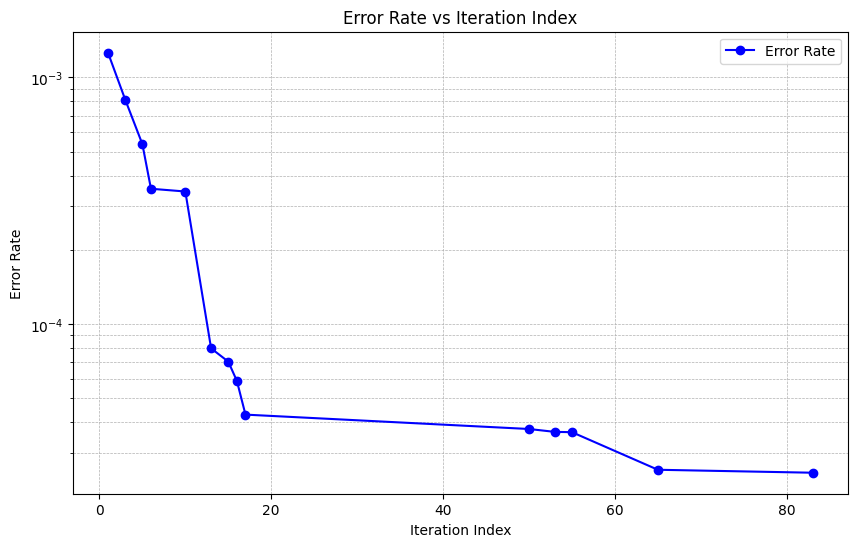

In [15]:
import matplotlib.pyplot as plt

# Data
iterations = [1, 3, 5, 6, 10, 13, 15, 16, 17, 50, 53, 55, 65, 83]
error_rates = [1.26e-03, 8.14e-04, 5.37e-04, 3.54e-04, 3.45e-04, 7.98e-05, 7.05e-05, 5.89e-05, 4.30e-05, 3.76e-05, 3.66e-05, 3.65e-05, 2.57e-05, 2.50e-05]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, error_rates, marker='o', linestyle='-', color='b', label='Error Rate')
plt.xlabel('Iteration Index')
plt.ylabel('Error Rate')
plt.title('Error Rate vs Iteration Index')
plt.yscale('log')  # Log scale for better visualization
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

Best error rate: 2.50E-05


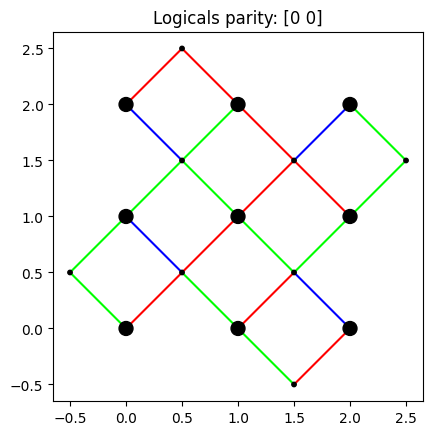

In [12]:
parity_info = code.deformation_parity_info(best_deformation)

print(f"Best error rate: {best_error_rate:.2E}")
code.show(parity_info)